In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

# Read Data

In [4]:
path = './'

In [5]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [6]:
dataTraining.index[200]

283

In [7]:
dataTraining.head()

,year,title,plot,genres,rating
0,1995,Major Payne,major benson winifred payne is being discharge...,"['Adventure', 'Comedy', 'Family']",6.1
2,2008,Outlander,"in N ad , in the iron age , a spacecraft c...","['Action', 'Adventure', 'Sci-Fi']",6.3
3,2011,Mission: Impossible - Ghost Protocol,"imf agent ethan hunt , who ' s been out for s...","['Action', 'Adventure', 'Thriller']",7.4
8,2001,Mockingbird Don't Sing,"on november N , N on the cbs evening news...","['Biography', 'Drama']",6.5
10,2011,Snow Flower and the Secret Fan,"in N th - century china , seven year old gir...","['Drama', 'History']",6.1


In [8]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [9]:
os.path.join(path, 'images_resize_gray', str(dataTraining.index[12]) + '_resize_gray.jpeg')

'./images_resize_gray\\23_resize_gray.jpeg'

# Read Images

In [10]:
image = io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[12]) + '_resize_gray.jpeg'))

In [11]:
pd.DataFrame(image).to_csv('image_array.csv', index_label='ID')

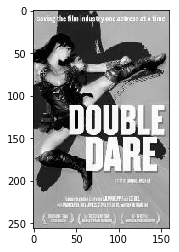

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

Read all images

In [11]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [13]:
images_trainingsvm = []
for i in tqdm(dataTraining.index):
    images_trainingsvm.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [01:33<00:00, 84.54it/s]


In [14]:
images_trainingsvm = np.stack(images_trainingsvm)
images_trainingsvm.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [15]:
images_testingsvm= []
for i in tqdm(dataTesting.index):
    images_testingsvm.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testingsvm = np.stack(images_testingsvm)

images_testingsvm.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:51<00:00, 66.25it/s]


((3383, 40960), 3383)

## Apply PCA

In [16]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_trainingsvm)

In [17]:
images_testing_pca = pca.transform(images_testingsvm)

# Create y

In [18]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [19]:
dataTraining['genres']

0                             [Adventure, Comedy, Family]
2                             [Action, Adventure, Sci-Fi]
3                           [Action, Adventure, Thriller]
8                                      [Biography, Drama]
10                                       [Drama, History]
12                                                [Drama]
14                       [Action, Crime, Drama, Thriller]
15                   [Adventure, Drama, Romance, Western]
17                               [Crime, Drama, Thriller]
18                                       [Comedy, Family]
19                             [Drama, Mystery, Thriller]
20                      [Action, Drama, Sci-Fi, Thriller]
23                                          [Documentary]
26                                             [Thriller]
27                    [Adventure, Comedy, Crime, Romance]
28                               [Comedy, Romance, Drama]
29                                                [Drama]
30            

In [20]:
y_genres

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 1]])

In [21]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

# Train multi-class multi-label model

In [38]:
clf = OneVsRestClassifier(SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None))

In [39]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [40]:
y_pred_genres = clf.predict(X_test)

In [41]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5039645828939322

# Apply models to test

In [22]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')